In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras import regularizers
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score

/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
from tensorflow.python.eager import context
print(context.num_gpus())

1


In [3]:
path = "/home/halliganbs/parsed_data.csv"

# One Hot Encodes the dataframe 
# creates an np array (number_samples, length_sample, number_values)
def one_hot_encode(df):
  n_samples = len(df['window'])
  X = np.zeros((n_samples, 501, 4))
  for i, seq in enumerate(df['window']):
    for j, nucleotide in enumerate(seq):
      # Possible Nucleotides: A, C, G, T
      if nucleotide == 'A':
        X[i,j,0] = 1
      elif nucleotide == 'T':
        X[i,j,1] = 1
      elif nucleotide == 'C':
        X[i,j,2] = 1
      elif nucleotide == 'G':
        X[i, j, 3] = 1
    
  return X

In [4]:
# Load Data
df = pd.read_csv(path)
x = one_hot_encode(df)

# sanity check
print(x.shape)
print(x[0, :, :])

y = df['enhancer'].to_numpy()

# might make n_splits = a variable so that when adding more I can just call it
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

(4428, 501, 4)
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


Test Values: [1, 2, 3, 4]


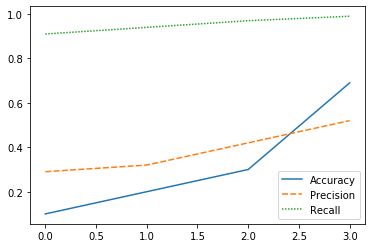

In [5]:
# Graph Results
def get_scores(scores):
  acc = []
  precision =[]
  recall = []
  for scr in scores:
    acc.append(scr[0])
    precision.append(scr[1])
    recall.append(scr[2])
  
  return acc, precision, recall

def graph_scores(acc, prec, recall, values, type="N/A"):
  print(type, 'Values:',values)
  all_data = [np.asarray(acc), np.asarray(prec), np.asarray(recall)]
  labels = np.array(['Accuracy', 'Precision', 'Recall'])
  sns.lineplot(hue=labels, data=all_data)
  plt.legend(labels)

test_val = [1,2,3,4]
test_scores = [[0.1,0.29,0.91], [0.2,0.32,0.94], [0.3,0.42,0.97], [0.69,0.52,0.99]]

a, p, r = get_scores(test_scores)
graph_scores(a, p, r, test_val, type='Test')

In [6]:
# build model based on paper

hidden_dims = 250 # needs verification

model = Sequential()
'''
1st Connvolutation layer
30 filters
size of filter 19
stride 1
'''
model.add(Conv1D(
    filters=30,
    kernel_size=19,
    strides=1,
    activation='relu',
    padding='same',
    kernel_regularizer=regularizers.l2(1e-6)
))

# Dropout Layer 1
model.add(Dropout(0.1))

# Max Pooling layer 1
model.add(MaxPooling1D(
    pool_size =2,
    strides = 2
))

'''
2nd Connvoluation layer
128 filters
filter size 5
stride 1
'''
model.add(Conv1D(
    filters=128,
    kernel_size=5,
    strides=1,
    activation='relu',
    padding='same',
    kernel_regularizer=regularizers.l2(1e-6)
))

# Dropout Layer 2
model.add(Dropout(0.1))

# Max Pooling layer 2
model.add(MaxPooling1D(pool_size=50,strides=2))

model.add(Flatten())

# Hidden Layer
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))





Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# fit model

model_acc = np.empty([5])
model_prec = np.empty([5])
model_recall = np.empty([5])

index = 0

for train_index, test_index in kf.split(x, y):
    
    # Get the data from the numpy arrays
    x_train, x_test = x[train_index, :, :], x[test_index, :, :]
    y_train, y_test = y[train_index], y[test_index]

    print('x_train shape:', x_train.shape)
    print('x_test shape:', x_test.shape)
    
    # Compile
    # loss needs to be L2-regularzation or Ridge Regression
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.fit(x_train, y_train,
              batch_size=100,
              epochs=100)
    
    # predict
    pred_prob = model.predict(x_test).reshape(-1)
    print(pred_prob.shape, y_test.shape)
    pred_y = np.ones(y_test.shape)
    pred_y[pred_prob < 0.5] = 0.0

    # SKlearn acc, pred, recall
    acc = accuracy_score(y_test, pred_y)
    prec = precision_score(y_test, pred_y)
    recall = recall_score(y_test, pred_y)

    # sanity check
    print('Trial Accuracy: ', acc)
    print('Trial Precision: ', prec)
    print('Trial Recall: ', recall)
    print()

    # add to model values
    model_acc[index] = acc
    model_prec[index] = prec
    model_recall[index] =recall

    index = index+1
    
# Get Average of the models
avg_model_acc = np.mean(model_acc)
avg_model_prec = np.mean(model_prec)
avg_model_recall = np.mean(model_recall)

# Add scores to list
print('Model Results')
print('Accuracy: ',avg_model_acc)
print('Precision: ', avg_model_prec)
print('Recall: ', avg_model_recall)
print()

x_train shape: (3542, 501, 4)
x_test shape: (886, 501, 4)
Epoch 1/100
3542/3542 [==============================] - 1s 195us/sample - loss: 0.0710 - acc: 0.9848
Epoch 2/100
3542/3542 [==============================] - 0s 122us/sample - loss: 0.0282 - acc: 0.9910
Epoch 3/100
3542/3542 [==============================] - 0s 117us/sample - loss: 0.0233 - acc: 0.9924
Epoch 4/100
3542/3542 [==============================] - 0s 120us/sample - loss: 0.0221 - acc: 0.9929
Epoch 5/100
3542/3542 [==============================] - 0s 117us/sample - loss: 0.0224 - acc: 0.9918
Epoch 6/100
3542/3542 [==============================] - 0s 118us/sample - loss: 0.0181 - acc: 0.9938
Epoch 7/100
3542/3542 [==============================] - 0s 119us/sample - loss: 0.0220 - acc: 0.9929
Epoch 8/100
3542/3542 [==============================] - 0s 118us/sample - loss: 0.0164 - acc: 0.9949
Epoch 9/100
3542/3542 [==============================] - 0s 120us/sample - loss: 0.0121 - acc: 0.9958
Epoch 10/100
3542/3542 [

3542/3542 [==============================] - 0s 120us/sample - loss: 0.0099 - acc: 0.9966
Epoch 81/100
3542/3542 [==============================] - 0s 119us/sample - loss: 0.0122 - acc: 0.9952
Epoch 82/100
3542/3542 [==============================] - 0s 115us/sample - loss: 0.0097 - acc: 0.9972
Epoch 83/100
3542/3542 [==============================] - 0s 118us/sample - loss: 0.0099 - acc: 0.9958
Epoch 84/100
3542/3542 [==============================] - 0s 121us/sample - loss: 0.0149 - acc: 0.9952
Epoch 85/100
3542/3542 [==============================] - 0s 119us/sample - loss: 0.0138 - acc: 0.9955
Epoch 86/100
3542/3542 [==============================] - 0s 121us/sample - loss: 0.0200 - acc: 0.9938
Epoch 87/100
3542/3542 [==============================] - 0s 118us/sample - loss: 0.0158 - acc: 0.9938
Epoch 88/100
3542/3542 [==============================] - 0s 118us/sample - loss: 0.0199 - acc: 0.9946
Epoch 89/100
3542/3542 [==============================] - 0s 119us/sample - loss: 0.02

3542/3542 [==============================] - 0s 114us/sample - loss: 0.0113 - acc: 0.9980
Epoch 37/100
3542/3542 [==============================] - 0s 118us/sample - loss: 0.0117 - acc: 0.9972
Epoch 38/100
3542/3542 [==============================] - 0s 117us/sample - loss: 0.0103 - acc: 0.9983
Epoch 39/100
3542/3542 [==============================] - 0s 120us/sample - loss: 0.0115 - acc: 0.9960
Epoch 40/100
3542/3542 [==============================] - 0s 121us/sample - loss: 0.0082 - acc: 0.9975
Epoch 41/100
3542/3542 [==============================] - 0s 119us/sample - loss: 0.0062 - acc: 0.9980
Epoch 42/100
3542/3542 [==============================] - 0s 123us/sample - loss: 0.0092 - acc: 0.9969
Epoch 43/100
3542/3542 [==============================] - 0s 119us/sample - loss: 0.0134 - acc: 0.9966
Epoch 44/100
3542/3542 [==============================] - 0s 121us/sample - loss: 0.0360 - acc: 0.9881
Epoch 45/100
3542/3542 [==============================] - 0s 121us/sample - loss: 0.01

Epoch 14/100
3543/3543 [==============================] - 0s 118us/sample - loss: 0.0109 - acc: 0.9958
Epoch 15/100
3543/3543 [==============================] - 0s 120us/sample - loss: 0.0104 - acc: 0.9972
Epoch 16/100
3543/3543 [==============================] - 0s 117us/sample - loss: 0.0127 - acc: 0.9969
Epoch 17/100
3543/3543 [==============================] - 0s 114us/sample - loss: 0.0393 - acc: 0.9901
Epoch 18/100
3543/3543 [==============================] - 0s 114us/sample - loss: 0.0182 - acc: 0.9935
Epoch 19/100
3543/3543 [==============================] - 0s 116us/sample - loss: 0.0123 - acc: 0.9955
Epoch 20/100
3543/3543 [==============================] - 0s 120us/sample - loss: 0.0127 - acc: 0.9960
Epoch 21/100
3543/3543 [==============================] - 0s 120us/sample - loss: 0.0207 - acc: 0.9932
Epoch 22/100
3543/3543 [==============================] - 0s 114us/sample - loss: 0.0100 - acc: 0.9972
Epoch 23/100
3543/3543 [==============================] - 0s 120us/sample

3543/3543 [==============================] - 0s 118us/sample - loss: 0.0062 - acc: 0.9983
Epoch 72/100
3543/3543 [==============================] - 0s 122us/sample - loss: 0.0042 - acc: 0.9992
Epoch 73/100
3543/3543 [==============================] - 0s 119us/sample - loss: 0.0124 - acc: 0.9960
Epoch 74/100
3543/3543 [==============================] - 0s 121us/sample - loss: 0.0089 - acc: 0.9972
Epoch 75/100
3543/3543 [==============================] - 0s 123us/sample - loss: 0.0039 - acc: 0.9994
Epoch 76/100
3543/3543 [==============================] - 0s 119us/sample - loss: 0.0085 - acc: 0.9969
Epoch 77/100
3543/3543 [==============================] - 0s 118us/sample - loss: 0.0085 - acc: 0.9986
Epoch 78/100
3543/3543 [==============================] - 0s 120us/sample - loss: 0.0151 - acc: 0.9946
Epoch 79/100
3543/3543 [==============================] - 0s 118us/sample - loss: 0.0094 - acc: 0.9966
Epoch 80/100
3543/3543 [==============================] - 0s 121us/sample - loss: 0.01

In [9]:
# validate model
# Model Results
# Accuracy:  0.9972909413220086
# Precision:  0.9950860702689145
# Recall:  0.9995485327313769
